# Introduction: the BSM model

#### Roland Grinis  -  Researcher at MIPT Nuclear Physics Methods lab  -  CTO at GrinisRIT (grinisrit.com)

In [1]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
torch.manual_seed(987654);

If you like dark plots:

In [2]:
import seaborn as sns
sns.set_style('darkgrid',
                {'axes.facecolor': '.2',
                'figure.facecolor': '0.1',
                'text.color': '.9',
                'grid.color': '.5',
                'xtick.color': '.9',
                'ytick.color': '.9'})

## Introduction

### What are *derivatives*?

Assets include bonds, stocks, commodities, FX rates, cryptocurrencies etc. 

Some examples:

#### Zero-coupon bond
A contract worth $P(t,T)$ at time $t$ that pays $P(T,T) = 1$ at maturity $t=T$

In [3]:
nday = 365 # Actual/365 day counting convention
t = torch.linspace(0,1,nday) # in years, maturity T = 1
time_to_maturity = 1 - t

Continuously-compounded spot interest rate 
$$
r(t,T) = - \frac{\log P(t,T)}{T-t}
$$

In [4]:
spot_interest_rate = 0.01 * torch.rand(nday) + 0.05 * torch.sigmoid(100 * (t-0.5))  # rate hike
bond = torch.exp(- time_to_maturity * spot_interest_rate)

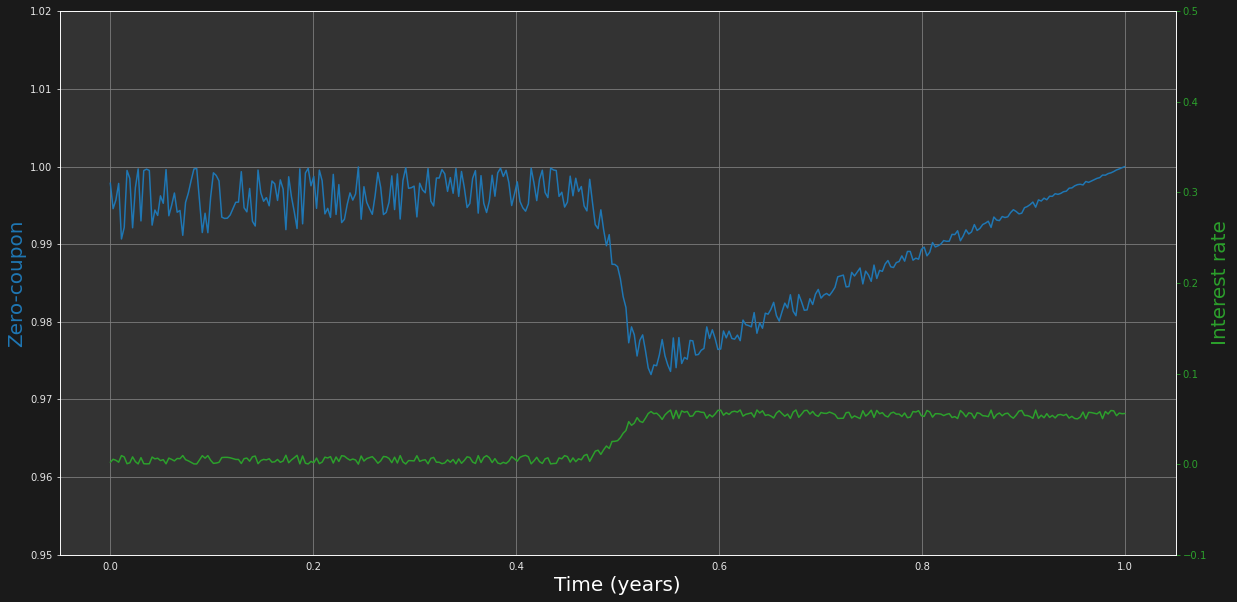

In [5]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_xlabel('Time (years)', color='white', fontsize=20)
ax1.set_ylabel('Zero-coupon', color='C0', fontsize=20)
ax1.plot(t.numpy(), bond.numpy(), 'C0')
ax1.set_ylim([0.95,1.02])

ax2 = ax1.twinx() 
ax2.grid(False)
ax2.set_ylabel('Interest rate', color='C2', fontsize=20)
ax2.plot(t.numpy(),spot_interest_rate.numpy(),color='C2')
ax2.set_ylim([-0.1,0.5])
ax2.tick_params(axis='y', colors='C2')

plt.show()

#### Zero-bond curve 
This is the map:

$$
T \rightarrow P(t,T), \quad T>t
$$ 

with corresponding continuously-compounded zero-coupon curve:

$$
T \rightarrow r(t,T), \quad T>t
$$ 

sometimes simply referred to as the *yield curve*. 

There are many different curves, e.g.
[US Libor](https://tradingeconomics.com/united-states/interbank-rate),
[US Treasuries](https://tradingeconomics.com/united-states/government-bond-yield) etc.



#### Dividends

Holding an asset might give the right to receive dividends. This is the case with many stocks and of course with FX, where holding a foreign currency gives the opportunity to receive interest rate from deposits.

This has to be modelled explicitly. So for the sake of simplicity (as we are mainly concerned with computational methods in those notes), **we assume no dividends** unless clearly stated otherwise.

#### Risky assets
Stock prices $S(t)$ and everything else is classified as *risky*. At the beginning of 20th century Bachelier proposed to model them as Browmian motion:

In [6]:
K = 100
alpha = 0.5 
vol = 5.0
S = K + (alpha + vol*torch.randn(nday)).cumsum(0) 

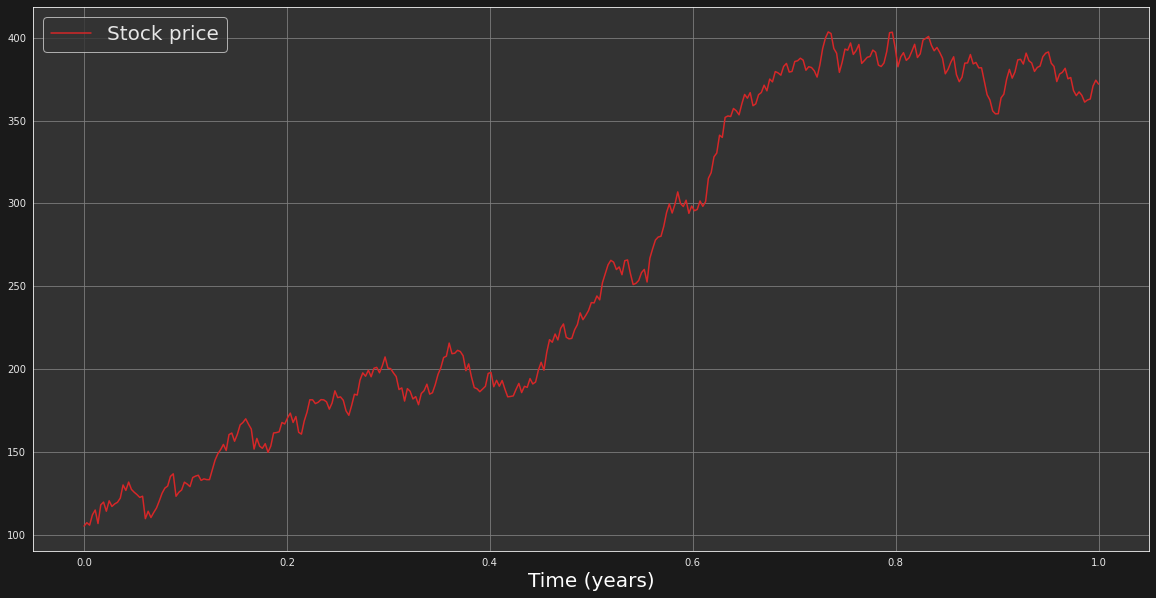

In [7]:
plt.figure(figsize=(20,10))
plt.plot(t.numpy(), S.numpy(),'C3',markersize=30, label='Stock price')
plt.legend(fontsize=20)
plt.xlabel('Time (years)', color='white', fontsize=20)
plt.show()

Mandelbrot noted in the 1960s that Brownian motion fails to produce *fat tails* typically observed in stock returns distribution. Modelling improvements include *stochastic volatility* and *jump processes*.

#### Financial Derivatives
It is a contract between a party (or a holder) and its counter-party (or the writer) entered at time $t=t_0$ and settleted:
* at maturity $t=T$ (European style)
* at any time $t \leq T$ (American style)
* at some specified exercise dates $t_1, t_2, \dots, T$ (Bermudan style)

according to a *payoff* function that depends on one or several underlying securities (assets, or other derivatives). 

The payoff might depend on the value of the underlyings at exercise date (vanilla contracts) or on the whole path between $t_0$ and maturity $T$ (exotic contracts).

Derivatives can be traded directly between parties, those are *over-the-counter* (OTC) contracts, or via a Central Counter Party (CCP), e.g. on an exchange such as CME, or a clearing house like the LCH.  

Examples:

#### Forwards/Futures

A *forward* is an OTC contract that obliges the holder, at time $t$, to buy the security $S_t$ from the writer at some future maturity time $T>t$ for a price:
$$
F(t,T) = \frac{S_t}{P(t,T)}
$$
called the *forward rate*. The payoff at maturity is:
$$
\mathcal{P}_F(S_T) = S_T - K
$$
Futures are exchange traded standardized versions of forwards. 

#### Example

Forwards/futures fixe the physical delivery of the underlying asset at maturity. They are traded on margin (see next section) and are typically used to gain leverage. 

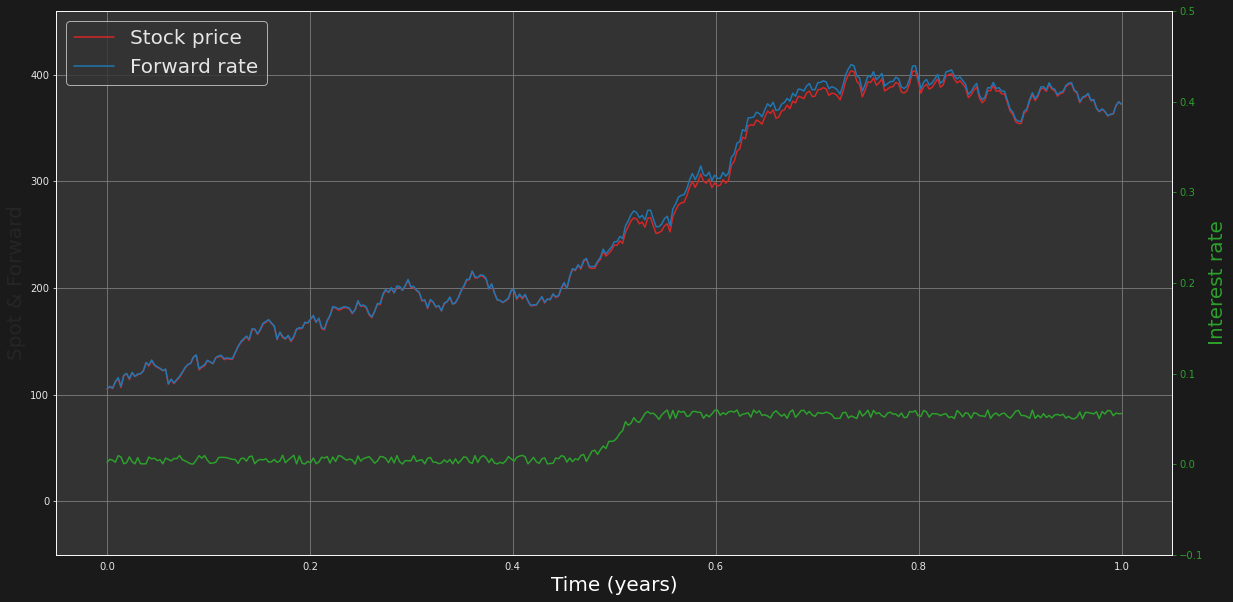

In [8]:
F = S / bond 
m = F.max()

fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_xlabel('Time (years)', color='white', fontsize=20)
ax1.plot(t.numpy(), S.numpy(),'C3',markersize=30, label='Stock price')
ax1.plot(t.numpy(), F.numpy(), 'C0', markersize=30, label='Forward rate')
ax1.set_ylabel('Spot & Forward', fontsize=20)
ax1.set_ylim([-50, m.item() + 50])
ax1.legend(loc='upper left',fontsize=20)

ax2 = ax1.twinx() 
ax2.grid(False)
ax2.set_ylabel('Interest rate', color='C2', fontsize=20)
ax2.plot(t.numpy(),spot_interest_rate.numpy(),color='C2')
ax2.set_ylim([-0.1,0.5])
ax2.tick_params(axis='y', colors='C2')

plt.show()

#### Swaps

An *interest rate swap* is a contract that obliges the holder (also called the receiver) to exchange with the writer (also called the payer) floating rate payments to be made at dates $\mathcal{T} = \{ T_0,T_1,\dots,T_n\}$ for a fixed *forward swap rate*:
$$
S_{\mathcal{T}}(t) = \frac{P(t,T_1) - P(t,T_n)}{A_{\mathcal{T}}(t)}
$$
where 
$$
A_{\mathcal{T}}(t) = \sum_{i=1}^{n}\tau_iP(t,T_i), \quad \tau_i = T_i - T_{i-1}
$$
is the *swap annuity*.

#### Example
Swaps are used to convert an existing loan from floating payments to a fixed rate. 

Forwards and swaps are example of *linear* products. Options represent another class of derivatives whose value depends non-linearly on the price of the underlying.  

#### Options

A *call option* gives the right to the holder (but not the obligation) to buy a security $S_{t_e}$ at an exercise date $t_e$ for a fixed price $K$, *the strike*. The payoff $\mathcal{P}_C$ is given by:
$$
\mathcal{P}_C(S_{t_e}) = (S_{t_e} - K)^{+} = \max\{S_{t_e} - K,0\}
$$
A *put option* gives the right (but not the obligation) to sell a security $S_{t_e}$ at an exercise date $t_e$ for the strike $K$. The payoff in this case is:
$$
\mathcal{P}_P(S_{t_e}) = (K - S_{t_e})^{+} 
$$ 

#### Example

Put options are popular for hedging against a sudden drop in the value of an investement in a risky asset. 

A typically strategy is the *covered call*: an investor holding a risky asset $S_t$ that appreciated in value wants to profit from further increase over $[t,T]$, but needs to protect from a potential downside risk. She proceeds buying an OTM put at strike $K_p<S_t$ financing the purchase by writing an OTM call with suitable strike $K_c > S_t$.

At time $T$, she can close extra profit for:
$$
K_c - S_t, \quad \text{if} \quad S_T \geq K_c,
$$
and in the worse case scenario she would lose:
$$
S_t - K_p, \quad \text{if} \quad S_T \leq K_p,
$$

In [9]:
td = int(nday*0.75)
St = S[td]
Kc = int((1+0.25*alpha)*St)
Kp = int((1-0.25*alpha)*St)
tT = t[td:]

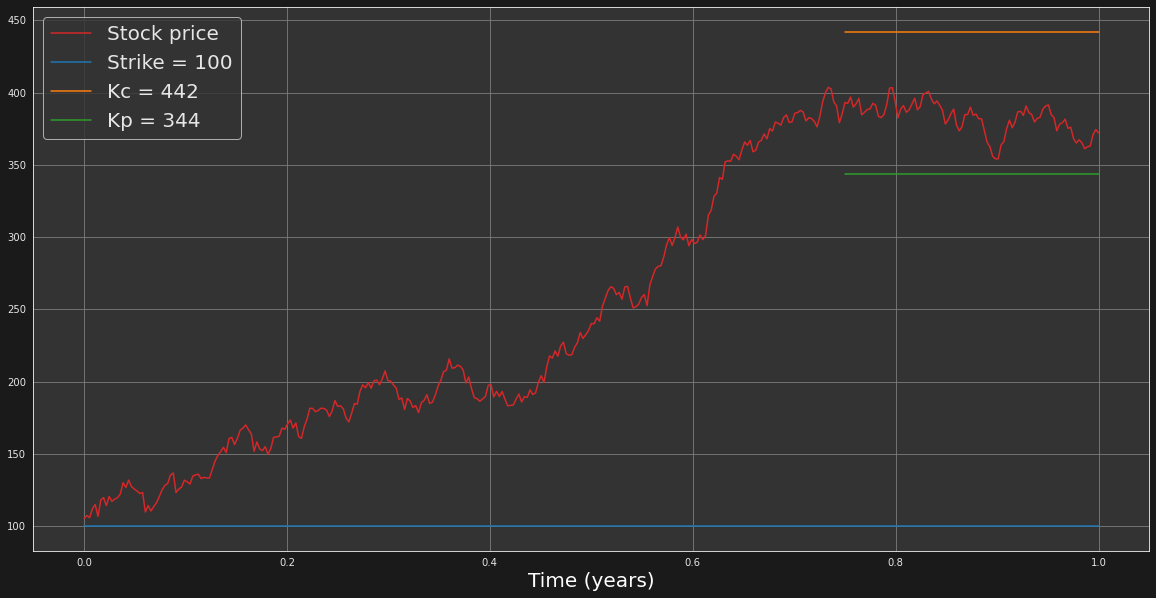

In [10]:
plt.figure(figsize=(20,10))
plt.plot(t.numpy(), S.numpy(),'C3',markersize=30, label='Stock price')
plt.plot(t.numpy(), K*torch.ones_like(S).numpy(),'C0',markersize=30, label=f'Strike = {K}')
plt.plot(tT.numpy(), Kc*torch.ones_like(tT).numpy(),'C1',markersize=30, label=f'Kc = {Kc}')
plt.plot(tT.numpy(), Kp*torch.ones_like(tT).numpy(),'C2',markersize=30, label=f'Kp = {Kp}')
plt.legend(fontsize=20)
plt.xlabel('Time (years)', color='white', fontsize=20)
plt.show()

#### Moneyness 
If the forward rate is equal to the strike, $F(t,T) = K$, we say that the option is *at-the-money* (ATM). For a call:
* if $K < F(t,T)$ the option is *in-the-money* (ITM)

* if $K > F(t,T)$ the option is *out-of-the-money* (OTM)

For a put it's the other way round. 

#### Swaptions
A *receiver swaption* gives the right (but not the obligation) to enter a swap where the floating rate payments will be exchanged for a fixed rate $K$. It is essentially a call option on the forward swap rate $S_{\mathcal{T}}(t)$ with strike $K$. 

A *payer swaption* gives the right (but not the obligation) to enter a swap as a payer, where a fixed rate $K$ will be exchanged for floating rate payments. It is a put option on $S_{\mathcal{T}}(t)$.

*Callables* are popular products that combine a swap together with an ATM Bermudan payer swaption enabling the holder to get out of fixed rate payements if the interest rates fall.


### How derivative contracts are traded?

The answer is easy: it is *always* the market that settles to a value for a derivative contract as a result of *demand and supply* dynamics. 

However, in some situations (especially for linear payoffs), the value of a derivative can be directly derived from the price of other securities. 

Any pricing methodology should obey the *no-arbitrage principle*. An *arbitrage* is a trading strategy that starts from zero balance and has positive expected return with no probability of loss, i.e. a *risk-free strategy*.

Therefore, unless the no-abritrage condition is satisfied, we cannot talk about any notion of fair value.

#### Example 

What is the value $V_F(t,T,K)$ of a contract at time $t$ that fixes its holder the price of the security $S_t$ to $K$ at some future time $T$?

It is essentially the value of forward contract where instead of using the forward rate $F(t,T)$ we have $K$. 

In fact the payoff at time $T$ is given by:
$$
V_F(T,T,K) = S_T - K = \max\{S_T - K,0\} - \max\{K - S_T,0\}
$$
This decomposition immediately gives us:
$$
V_F(t,T,K) = V_C(t,T,K) - V_P(t,T,K)
$$
where $V_C(t,T,K)$ and $V_P(t,T,K)$ are the values at time $t$ of the European call and put options respectively with maturity $T$ and strike $K$.
On the other hand, we claim that:
$$
V_F(t,T,K)  = P(t,T) \left(F(t,T) - K \right)
$$
This can be obtained by no-arbitrage arguments:

* if $V_F(t,T,K_0) > P(t,T) \left(F(t,T) - K_0\right)$, for some strike $K_0$, we trade in the bond to finance the purchase of the security and stand as a writer in a $V_F$ contract at strike $K_0$:
$$
\frac{V_F(t,T,K_0) - S_t}{P(t,T)} P(t,T) + S_t - V_F(t,T,K_0) = 0
$$
which has no value at time $t$, but at time $T$ this portfolio is worth:
$$
\frac{V_F(t,T,K_0) - S_t}{P(t,T)} + K_0 > 0
$$
which is a guaranteed win. That's arbitrage.
* if $V_F(t,T,K_0) < P(t,T) \left(F(t,T) - K_0\right)$, we trade in the bond to finance the short sell of the security and buy a $V_F$ contract at strike $K_0$:
$$
\frac{S_t - V_F(t,T,K_0)}{P(t,T)} P(t,T) - S_t + V_F(t,T,K_0) = 0
$$
Again, this portfolio which has no value at time $t$, becomes:
$$
\frac{S_t - V_F(t,T,K_0)}{P(t,T)} - K_0 > 0
$$
at time $T$ which is arbitrage.

Transaction costs and the risk of counter-party default are ignored in arbitrage arguments because we are only concerned with price dynamics.


#### Put-Call Parity

The previous example has lead to us to the identity:
$$
V_C(t,T,K) - V_P(t,T,K) = P(t,T) \left(F(t,T) - K \right)
$$
which is called the *put-call parity*. As a consequence, we get that the European ATM put and call have same value:
$$
V_C(t,T,F(t,T)) = V_P(t,T,F(t,T))
$$
Moreover, it costs nothing to enter a forward contract. But once purchased, the value of this contract will evolve according to $V_F$.

#### Exercise 
Show that it costs nothing to enter the interest rate swap.

#### Why do we need models?

Nowdays, derivatives are traded on margin. When a party and a counter-party enter a trade, only a certain percent of the contract value is exchanged: the *variation margin*. 

Each party then deposits funds that should cover the *initial margin*: this is the potential depreciation in the value of the contract due to moves in the market, and also account for the possiblity of counter-party default. This is based on sensitivity calculations for the value of the derivative which requires modelling.

If a party incurs a loss which eats deep into the initial margin down to a level called the *maintenance margin*, the party will have to give away its losses and close the trade, or deposit more funds (this is called a *margin call* for exchange traded derivatives). But since the latest Basel agreements, due to the downfall of Lehman Brothers in 2008, those strict rules also concern the OTC market.

Moreover, the regulators require that the overall portfolio of large banks has small sensitivity to market movements, i.e. it is *market neutral*, and is well diversified. 


#### Who are the *quants*?

Front office: 
* quant traders
* strategist (strats)
* quant modellers 
* quant developers

Back office:
* risk management
* regulatory 

## Diffusion processes

We consider $n$-dimensional diffusion processes $\textbf{X}_t$ over a probability space $\left( \Omega,  \mathbb{P} \right)$. The filtration $\mathcal{F}_t$ is generated by $m$ independent Wiener processes $\textbf{W}_t$. Any non-degenerate correlation configuration can be reduced to the SDE for $\textbf{X}_t$:
$$
\text{d}\textbf{X}_t = \mu_t(\textbf{X}_t)\text{d}t + \sigma_t(\textbf{X}_t)\text{d}\textbf{W}_t
$$
with $\mu_t$ an $n$-dimensional drift and $\sigma_t$ denoting a volatility $n \times m$-matrix. Well-posedness is established for Lipschitz bounds on $\mu_t$ and  $\sigma_t$.

Ito formula reads for $\textbf{Y}_t = f(t, \textbf{X}_t)$:
$$
\text{d}\textbf{Y}_t = \left( \frac{\partial f}{\partial t} + \mu_t^{*} \nabla_x f + \frac{1}{2} \text{tr} \left[ \sigma_t^{*} \cdot \nabla_x^2 f \cdot \sigma_t \right] \right) \text{d}t + \nabla_x^{*} f \cdot \sigma_t \text{d}\textbf{W}_t
$$



Conditional expectations:
$$
g(t, x) = \mathbb{E} \left[ h(\textbf{X}_T) | \textbf{X}_t=x \right]
$$
satisfy the Feynman-Kac equation:
$$
\frac{\partial g}{\partial t} + \mu_t^{*} \nabla_x g + \frac{1}{2} \text{tr} \left[ \sigma_t^{*} \cdot \nabla_x^2 g \cdot \sigma_t \right] = 0
$$
with initial condition $g(T, x) = h(x)$.

#### Exercise
Derive the Feyman-Kac formula using the law of iterated expectations:
$$
\mathbb{E} \left[ h(\textbf{X}_T) | \mathcal{F}_s \right] = \mathbb{E} \left[ \mathbb{E} \left[ h(\textbf{X}_T) | \mathcal{F}_t \right] | \mathcal{F}_s \right]
$$
for $s \leq t$.

Transition probabilities:
$$
p(t,T,x,y) = \mathbb{P} \left( \textbf{X}_T = y | \textbf{X}_t = x \right)
$$
so that:
$$
g(t, x) = \int h(y)p(t,T,x,y)dy
$$
satisfy the Kolmogorov backward equation:
$$
\frac{\partial p}{\partial t} + \mu_t^{*} \nabla_x p + \frac{1}{2} \text{tr} \left[ \sigma_t^{*} \cdot \nabla_x^2 p \cdot \sigma_t \right] = 0
$$
with initial condition $p(t,t,x,y) = \delta(x-y)$.

#### Euler Scheme

The simplest discretisation for $\textbf{X}_t$ over time steps $t_{i+1} = t_i + \Delta t$ compatible with Ito's integral is the explicit Euler scheme:
$$
\textbf{X}_{t_{i+1}}^{\Delta t} = \textbf{X}_{t_i}^{\Delta t} + \mu_t(\textbf{X}_{t_i}^{\Delta t})\Delta t + \sigma_t(\textbf{X}_{t_i}^{\Delta t}) \Delta t^{\frac{1}{2}}\Delta\textbf{W}
$$
where $\Delta\textbf{W}$ follows the standard normal distribution.

Strong convergence at some given time slice $t_i=T$ has asymptotics:
$$
\mathbb{E} \left( | \textbf{X}_T^{\Delta t} - \textbf{X}_T | \right) = O(\Delta t^{\frac{1}{2}})
$$
which is considerably worse than $O(\Delta t)$ for ODEs.

Weak convergence for the Monte-Carlo estimator:
$$
\textbf{V}^{\Delta t} =  \frac{1}{N} \sum_{k=0}^{N} \mathcal{P}(\textbf{X}_T^{\Delta t})
$$

of $\textbf{V} = \mathbb{E} \left[ \mathcal{P}(\textbf{X}_T) \right]$, for some payoff $\mathcal{P}$,  exhibits bias:
$$
\begin{split}
\text{MSE}(\textbf{V}^{\Delta t}) & =  \mathbb{E} \left[ \left( \textbf{V}^{\Delta t} - \textbf{V} \right)^2 \right] \\
 & =  \left( \mathbb{E} \left[\textbf{V}^{\Delta t}\right] - \textbf{V} \right)^2 + \mathbb{E} \left[ \left(\textbf{V}^{\Delta t} -\mathbb{E} \left[\textbf{V}^{\Delta t} \right] \right)^2 \right] \\
 & = \text{Bias}(\textbf{V}^{\Delta t})^2 + \text{Var}(\textbf{V}^{\Delta t}) \\
 & = O(\Delta t^2) + O(\frac{1}{N})
\end{split}
$$
beyond the central limit asymptotics.


#### Geometric Brownian Motion (GBM)

This is the simplest strictly positive process $S_t > 0$ with constant drift and volatility:
$$
\frac{\text{d}S_t}{S_t} = \mu \text{d}t + \sigma\text{d}W_t
$$
It's more convenient to work in log-space $Y_t = \log S_t$:
$$
\text{d}Y_t = \left(\mu - \frac{1}{2} \sigma^2\right)\text{d}t + \sigma\text{d}W_t
$$
from Ito's formula. 

In [11]:
# no drift mu=0
sigma = torch.tensor(0.25).requires_grad_() 
S0 = torch.tensor(100.0).requires_grad_()

num_paths = 100000

Yt = (- 0.5 * sigma.pow(2)) * t[1:].reshape((1, nday-1)) \
    + torch.cumsum(
    sigma * t.diff().sqrt().reshape((1,nday-1)) * torch.randn((num_paths, nday-1)), 1)
St = S0 * Yt.exp()

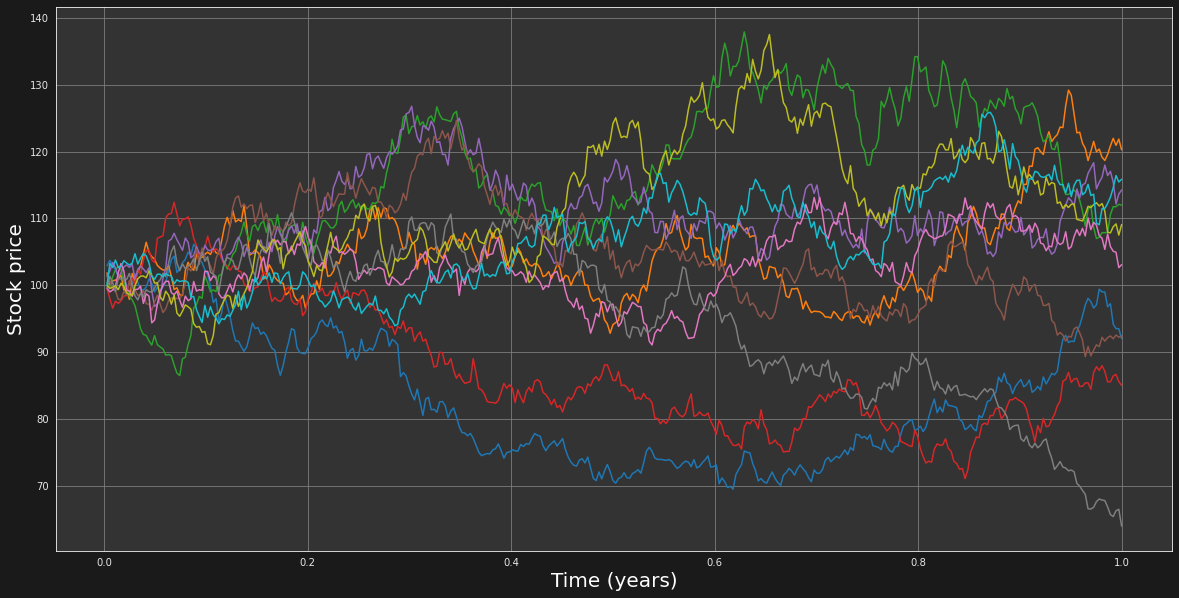

In [12]:
plt.figure(figsize=(20,10))
plt.plot(t[1:].numpy(), St.detach()[:10].numpy().squeeze().T)
plt.xlabel('Time (years)', color='white', fontsize=20)
plt.ylabel('Stock price', color='white', fontsize=20)
plt.show()

In [13]:
# Lookback option
payoff = torch.max(St,1).values

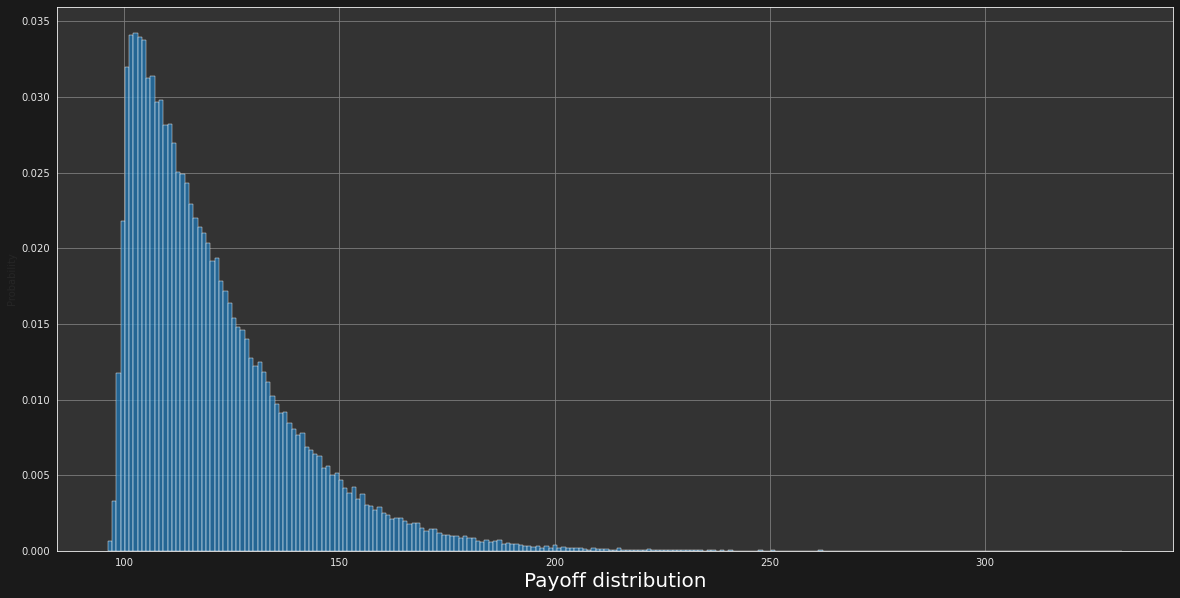

In [14]:
plt.figure(figsize=(20,10))
sns.histplot(data=payoff.detach().numpy(), stat='probability');
plt.xlabel('Payoff distribution', color='white', fontsize=20)
plt.show()

In [15]:
PV = payoff.mean() # Present Value
PV

tensor(120.6925, grad_fn=<MeanBackward0>)

In [16]:
delta, kappa = torch.autograd.grad(PV, [S0, sigma])
print(f'Delta: {delta.item()}')
print(f'Kappa: {kappa.item()}')

Delta: 1.2069246768951416
Kappa: 88.80655670166016


## References

* Seydel, R.U. *Tools for Computational Finance*, 6th edition, Springer V., London (2017)
* Shreve, S.E. Stochastic Calculus for Finance I & II, Springer, New York (2004)
* Grzelak, L.A. et al. *Mathematical Modeling and Computation in Finance: With Exercises and Python and MATLAB Computer Codes*, World Scientific Pub. (2019)
* Savine, A. Modern Computational Finance: AAD and Parallel Simulations, Wiley (2018)